### DBSCAN implementation
- build the data
- parameters: minPts, epsilon ($\epsilon$)
- define `core` points $p$ that are surrounded by at least minPts within an epsilon radius
- define `directly reachable points` $q_i$ from $p$: that lie within a circle of radius $\epsilon$ around $p$
- define `reacheable points` $q_i$ from $p$: meaning points that are linked by a chain of directly reacheable points
- define `outliers`: points that are no reacheable by any points

#### Build the data

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [11]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [12]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [13]:
from torch.distributions import MultivariateNormal

In [14]:
n_centers = 5
n_pts = 1500
centers = torch.rand(n_centers, 2)*300-150
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-105.287,   -4.034],
         [ 145.698,  -99.480],
         [  25.183,   58.080],
         [  24.925, -111.469],
         [  21.637,  127.452]]))

In [15]:
g = MultivariateNormal(centers[0], torch.diag(tensor([5.,5.])))

In [16]:
g.sample((3,))

tensor([[-104.506,   -2.888],
        [-102.589,   -0.893],
        [-110.551,   -1.490]])

In [17]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [18]:
data_l = [generate_points(c,100.) for c in centers]
data = torch.cat(data_l)

In [19]:
data.shape

torch.Size([7500, 2])

In [61]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1, alpha=0.3)
        plt.plot(*c, marker='x', markersize=7, color='k', mew=5, alpha=1)
        plt.plot(*c, marker='x', markersize=3, color='orange', mew=1)

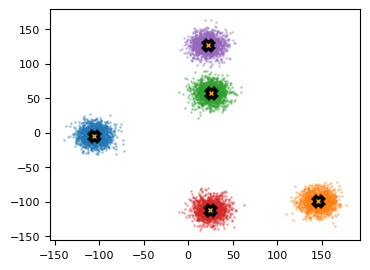

In [62]:
plot_data(centers, data_l)

#### Build the algorithm:
- for each point find the surrounding points within an $\epsilon$ radius 
- identify the core points with `num_neighbors` > `minPts`
- sort all non-core points between nearby clusters if they're within $\epsilon$ of a cluster and noise

> We can do it sequentially, point by point. This implies that it'll firs exhaust the points of a cluster to then proceed to the next cluster.

> We can also try to accelerate the calculation if possible by using a vectorial implementaiton. We'll try that:

In [14]:
X = data.clone()

In [15]:
X = X[torch.randperm(X.shape[0])]

In [16]:
x0 = X[0]
x1 = X[1]
(x0-X)[:3], (x1-X)[:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [17]:
X[:,None,:].shape, X.shape

(torch.Size([7500, 1, 2]), torch.Size([7500, 2]))

> Distance calculation with einsum:

In [18]:
Diff = X[:,None,:]-X
Diff[0,:3], Diff[1,:3]

(tensor([[   0.000,    0.000],
         [-125.036,  162.456],
         [  -0.284,    6.731]]),
 tensor([[ 125.036, -162.456],
         [   0.000,    0.000],
         [ 124.752, -155.725]]))

In [19]:
D = torch.einsum('ijk,ijk->ij', Diff, Diff).sqrt()
D.shape, D

(torch.Size([7500, 7500]),
 tensor([[  0.000, 205.003,   6.737,  ..., 205.918, 190.306, 185.311],
         [205.003,   0.000, 199.533,  ...,   8.269,  19.068, 136.821],
         [  6.737, 199.533,   0.000,  ..., 200.612, 184.604, 178.605],
         ...,
         [205.918,   8.269, 200.612,  ...,   0.000,  25.441, 144.476],
         [190.306,  19.068, 184.604,  ...,  25.441,   0.000, 119.664],
         [185.311, 136.821, 178.605,  ..., 144.476, 119.664,   0.000]]))

In [20]:
def distance_matrix(X): 
    Diff = X[:,None,:]-X
    return torch.sqrt(torch.einsum('ijk,ijk->ij', Diff, Diff))

> We define the DBSCAN parameters $\epsilon$ and `minPts`:

In [21]:
epsilon = 3
minPts = 20

> Now let's determine the neighbors of each point within a circle of radius $\epsilon$ :

In [22]:
def epsilon_cut(D, epsilon): return torch.where(D<epsilon, 1,0)

In [401]:
%timeit -n 3 epsilon_cut(D,epsilon)

81.6 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [23]:
neighbors = epsilon_cut(D, epsilon)
neighbors

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [24]:
neighbors.sum()

tensor(263490)

> Core points are defined as having `minPts` neighbors:
We will need the neighbors matrix, an $n \times n$ symmtric matrix where each row $i$ corresponds to a binary vector indicating if point $x_i$ is neighbor with points $x_j$, $j \in n$  

In [25]:
def core_pts_calc(D, epsilon, minPts):
    neighbors = epsilon_cut(D, epsilon)
    return neighbors, torch.where(neighbors.sum(1)>=minPts, 1,0)

In [28]:
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)

In [29]:
core_bool.shape, neighbors.shape

(torch.Size([7500]), torch.Size([7500, 7500]))

In [30]:
X.shape

torch.Size([7500, 2])

In [31]:
%timeit -n 30 X_c = X[core_bool==1]

The slowest run took 28.55 times longer than the fastest. This could mean that an intermediate result is being cached.
422 µs ± 599 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [32]:
%timeit -n 30 X*core_bool[:,None]

53.3 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [33]:
def plot_core(X, core_bool):
    X_c = X[core_bool==1]
    X_nc = X[core_bool==0]
    fig, ax = plt.subplots(figsize=(5,3))
    ax.scatter(X_c[:,0], X_c[:,1], s=1, alpha=0.15)
    ax.scatter(X_nc[:,0], X_nc[:,1], s=1, c='grey', alpha=0.3)
#     c = plt.Circle((-35.5, 49), 2, color='k', fill=False)
#     ax.add_patch(c)

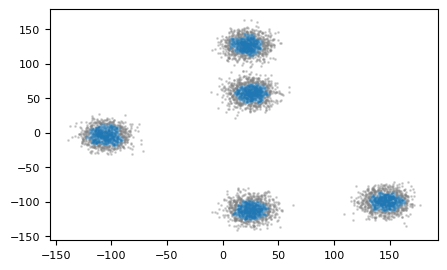

In [34]:
plot_core(X, core_bool)

 Now let's build the cluster search algorithm, the steps are as follows:

>- initialize a cluster vector of length n_points  -  initialize at 0 $\equiv$ belongs to no cluster
>- get the neighbor matrix of only the core points
>- go through the core points 
    - verify if any of the neighbors already has a cluster value 
    - assign all neighbors to the same cluster value: either the min cluster value found among the neighbors or a new one if all neighbors are assigned to cluster 0.
    - in case neighbor points are already assigned, go through their previous cluster values and assign all the points that share these cluster numbers to the same min value obtained above. This will prevent small artefact clusters or points to remain mis-clustered next to a larger cluster because they were assigned at different moments in the loop. With the scikit-learn implementation we can sometimes see such artefact clusters appear in the cluster predictions (we'll see an exemple of that later, but a better choice of 'eps' and 'minPts' resolves it). 

> We'll need to use a reverse function to find the indexes at which the vector has a given value, we can use `torch.where` or `(tensor_0 == x).nonzero()`: <br>
*However we should replace all .nonzero() by torch.where() when using CUDA to avoid a slow down due to CPU synchronization, see [here](https://pytorch.org/docs/stable/generated/torch.nonzero.html#torch.nonzero).*

In [31]:
torch.where(core_bool)[0]

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [32]:
core_bool.nonzero().squeeze()

tensor([   0,    1,    2,  ..., 7497, 7498, 7499])

In [33]:
%timeit -n 1000 torch.where(core_bool==0)[0]

45.8 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
%timeit -n 1000 core_bool.nonzero().squeeze()

42 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
%timeit -n 1000 (core_bool==0).nonzero().squeeze()

44.6 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


> We initialize the cluster vector and build the cluster search loop trying to keep vectorial calculations as much as possible :

In [33]:
cluster = torch.zeros(X.shape[0])

In [34]:
core_n_idx = core_bool.nonzero().squeeze()
neighbors.shape, core_n_idx.shape

(torch.Size([7500, 7500]), torch.Size([5435]))

In [35]:
neighbors[core_n_idx].shape

torch.Size([5435, 7500])

In [43]:
%timeit -n 5 neighbors[core_n_idx][0].nonzero().squeeze()

47.9 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


> In the outer loop we go through all the core points in the `neighbors` matrix, in the inner loop we verify if the neighbors already have a value assigned to them. If they do, the idea is to find the smaller cluster value present and assign it to all of them (as they are all neighbors to a core point they are part of the same cluster). A second check is performed to assign all the other points that share these cluster values to the same min value selected above.<br>
This step is costly, we can implement it with an index search via torch.isin() or by a loop through the cluster values of the neighbors. The for loop is quite faster.

In [36]:
i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
#     u_idx = torch.where(u)[0]
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()] # nearest neighbors indexes that already have a non-zero cluster value
#         nn_idx = u_idx[torch.where(cluster[u_idx])[0]]
        c_num = cluster[nn_idx].min()                      # cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()
#         cluster[all_n_idx] = c_num
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
#             idx = torch.where(cluster==n)[0] 
            cluster[idx] = c_num
        cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

In [37]:
torch.unique(cluster)

tensor([0., 1., 2., 5., 6., 7.])

> `torch.isin` is very slow, it is faster to perform a for loop in python, so we replace this part:

```python
all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze()
cluster[all_n_idx] = c_num
```
>by this:

```python
for n in cluster[nn_idx].unique():
    idx = (cluster==n).nonzero().squeeze()
    cluster[idx] = c_num
    cluster[u_idx] = c_num
```

> see the comparison below:

In [46]:
%%timeit -n 2
D = distance_matrix(X)
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)
core_n_idx = core_bool.nonzero().squeeze()
cluster = torch.zeros(X.shape[0])

i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()]                   # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                                        # smallest cluster number
        all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze() # all points that share a common cluster number with the nearest neighbors (sub graph)
        cluster[all_n_idx] = c_num
#         for n in cluster[nn_idx].unique():
#             idx = (cluster==n).nonzero().squeeze()
#             cluster[idx] = c_num
#         cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

3.06 s ± 626 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [47]:
%%timeit -n 2
D = distance_matrix(X)
neighbors, core_bool = core_pts_calc(D, epsilon, minPts)
core_n_idx = core_bool.nonzero().squeeze()
cluster = torch.zeros(X.shape[0])

i = 1
for u in neighbors[core_n_idx]:
    u_idx = u.nonzero().squeeze()
    if cluster[u_idx].sum() > 0:
        nn_idx = u_idx[cluster[u_idx].nonzero().squeeze()]                   # nearest neighbors indexes that already have a non-zero cluster value
        c_num = cluster[nn_idx].min()                                        # smallest cluster number
#         all_n_idx = torch.isin(cluster, cluster[nn_idx]).nonzero().squeeze() # all points that share a common cluster number with the nearest neighbors (sub graph)
#         cluster[all_n_idx] = c_num
        for n in cluster[nn_idx].unique():
            idx = (cluster==n).nonzero().squeeze()
            cluster[idx] = c_num
        cluster[u_idx] = c_num
    else:
        cluster[u_idx] = i
        i += 1

1.43 s ± 84.7 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


> Let's wrap up these steps in a function `dbscan` and plot the clusters:

In [35]:
def plot_clusters(X, clusters, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    ax.scatter(X[:,0], X[:,1], s=1, c=clusters)

In [36]:
def find_c(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    i = 1
    for u in neighbors[core_n_idx]:
        u_idx = torch.where(u)[0]
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            if u_idx.shape == nn_idx.shape: continue          # if the point and its neighbors are already labelled, continue
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [37]:
def dbscan(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust = find_c(neighbors, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

> We can implement a fast version of the find_cluster function by removing the neighbors search when the core point was already 

In [38]:
def find_c_fast(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    core_done = torch.tensor([-1]) # just to initialize the tensor
    i = 1
    for k in core_n_idx:
        if k in core_done: continue
        u = neighbors[k]
        u_idx = torch.where(u)[0]
        core_done = torch.cat((core_done,u_idx))
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [39]:
def dbscan_fast(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust = find_c_fast(neighbors, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

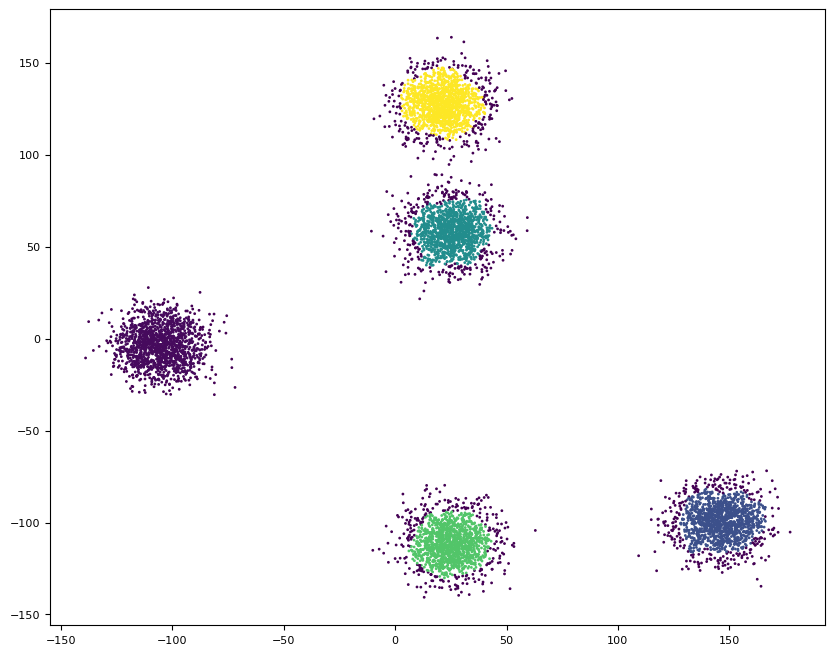

In [40]:
cl = dbscan(data, 3, 20, plot=True)

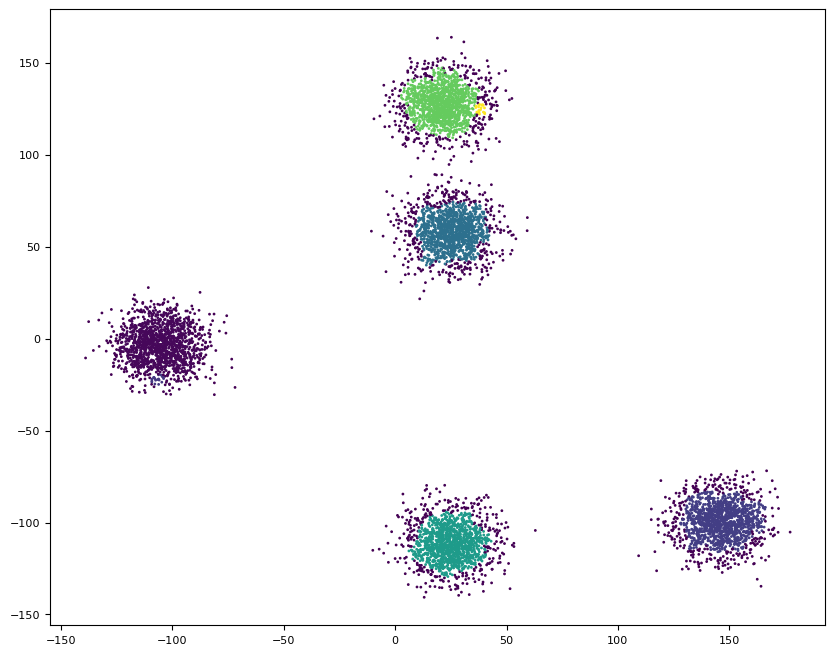

In [41]:
cl = dbscan_fast(data, 3, 20, plot=True)

In [48]:
cl.unique()

tensor([ 0.,  1.,  9., 10., 20., 30., 42., 55.])

With the fast version, we obtain a better performance but some artefact clusters appear similarly to the sklearn implementation. It is due to the possibility for points to be labellized as already assigned that will never overlap with another core point neighborhood for $\epsilon$ small enough.

In [63]:
%timeit -n 2 _ = dbscan(data,3,20)

729 ms ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [213]:
%timeit -n 2 _ = dbscan_fast(data,3,20)

509 ms ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


>Let's compare with the scikit-learn implementation of DBSCAN:

In [42]:
from sklearn.cluster import DBSCAN

In [43]:
y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

In [44]:
%timeit -n 2 y_pred = DBSCAN(eps=3, min_samples=20).fit_predict(X)

41.3 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


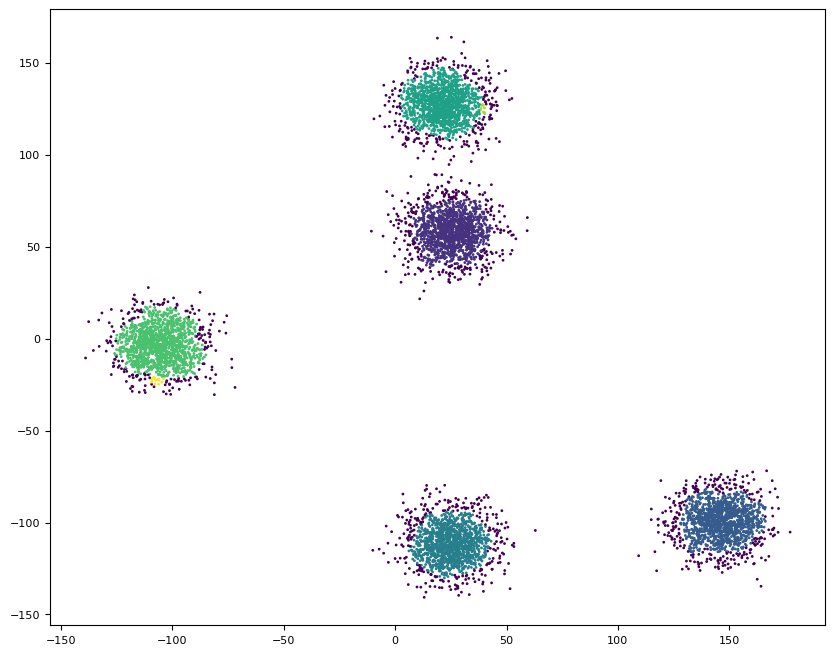

In [45]:
plot_clusters(X, y_pred)

We can see that there are some islands of residual clusters in the middle of larger clusters. They likely do not check for all the core points that were assigned to another cluster earlier on and not converted to their final cluster, resulting in artefacts.

Our implementation yields more accurate results than sklearn's DBSCAN(in cython) but at the same time is **30x** slower. We could possibly fasten it by using GPU acceleration.

#### Animation of the cluster search

To make the animation fluid, we can pre run the algorithm and find the point indexes that are both core and make a change in the cluster allocation. The `find_c` functions are modified to get these indexes in the list `midx`:

In [112]:
# function to get the main indexes that effectively assign new points to clusters
def find_c_for_movie_only(neighbors, core_bool):
    midx = []
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    i = 1
    for j,u in enumerate(neighbors[core_n_idx]):
        u_idx = torch.where(u)[0]
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            if u_idx.shape == nn_idx.shape: continue          # if the point and its neighbors are already labelled, continue
            midx.append(j)
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            midx.append(j)
            clusters[u_idx] = i
            i += 1
    return clusters, midx

In [113]:
# function to verify the clusters obtained when looping only through indexes in midx
def find_c_from_midx(neighbors, core_bool):
#     midx = []
    clusters = torch.zeros(core_bool.shape)
    core_n_idx = torch.where(core_bool)[0]
    i = 1
    for j in midx:
        u = neighbors[core_n_idx][j]
        u_idx = torch.where(u)[0]
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            if u_idx.shape == nn_idx.shape: continue          # if the point and its neighbors are already labelled, continue
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [114]:
def dbscan_only_movie(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust, midx = find_c_for_movie_only(neighbors, core_bool)
#     clust = find_c_from_midx(neighbors, core_bool)
    if plot: plot_clusters(X, clust)
    return clust, midx
#     return clust

In [115]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

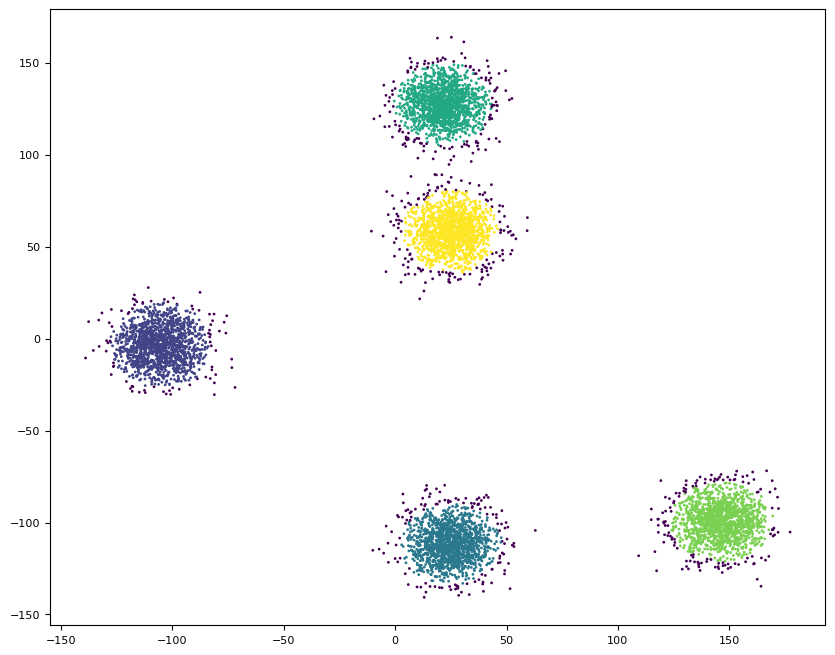

In [119]:
_, m_idx = dbscan_only_movie(X, 7, 110, plot=True)

In [120]:
midx = tensor(m_idx)
midx.shape, midx

(torch.Size([299]),
 tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
           22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
           44,   45,   47,   50,   51,   52,   53,   54,   55,   56,   57,   58,   60,   61,   63,   64,   65,   66,   67,   70,   72,   73,
           74,   76,   78,   79,   81,   85,   86,   87,   88,   90,   94,   95,   96,   99,  100,  103,  105,  107,  112,  114,  116,  117,
          118,  119,  121,  126,  127,  131,  133,  136,  140,  141,  145,  146,  147,  150,  156,  157,  168,  170,  172,  175,  177,  178,
          187,  189,  191,  192,  195,  196,  199,  202,  204,  206,  213,  217,  226,  227,  232,  239,  244,  253,  254,  255,  256,  258,
          262,  264,  265,  266,  271,  273,  278,  286,  289,  299,  306,  311,  312,  313,  314,  315,  318,  323,  334,  336,  338,

In [121]:
def one_step(d):
    global i
    if d:
        u = neighbors[core_n_idx][midx[d-1]]
        u_idx = torch.where(u)[0] 
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            if u_idx.shape == nn_idx.shape: return            # if the point and its neighbors are already labelled, continue
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    ax.clear()
    plot_clusters(X, clusters, ax=ax)

In [122]:
eps = 7
minPts = 110
# X = data.clone()                  # WITH midx WE CANNOT REDEFINE AND SHUFFLE THE DATA AGAIN
# X = X[torch.randperm(X.shape[0])] # WITH midx WE CANNOT REDEFINE AND SHUFFLE THE DATA AGAIN
D = distance_matrix(X)
neighbors, core_bool = core_pts_calc(D, eps, minPts)
clusters = torch.zeros(core_bool.shape)
core_n_idx = torch.where(core_bool)[0]
i = 1

In [123]:
midx.shape[0]

299

In [124]:
n_frames = midx.shape[0]+1
# n_frames = 30
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, one_step, frames=n_frames, interval=70, repeat=False)
plt.close()
# HTML(ani.to_jshtml())
HTML(ani.to_html5_video())
# ani.save('test.mp4')

### Using Rtrees and Local Sensitive Hashing

We'll modify a bit the functions, we'll need to:
- define a iterator for the data to quickly create the index graph
- create a table of only the `minPts` nearest neighbors with index.Index().nearest()
- build the distance matrix of dims (N, minPts)
- another possibility is to create a circle object of radius $\epsilon$ around each point and use thin index.Index().interesect method or rtrees.


#### RTrees

In [67]:
from rtree import index

In [ ]:
class idx_format():
    def __init__(self, X):
        self.X = X
        self.step = 0
        self.max_step = X.shape[0]
    def __iter__(self): return self
    def __next__(self):
        if self.step >= self.max_step: raise StopIteration
        pt = (self.step, (*self.X[self.step], *self.X[self.step]), None)
        self.step += 1
        return pt

In [ ]:
X = data.clone()

In [ ]:
X_it = iter(idx_format(X))
idx = index.Index(list(X_it))

In [ ]:
def distance_matrix(X): 
    Diff = X[:,None,:]-X
    return torch.sqrt(torch.einsum('ijk,ijk->ij', Diff, Diff))

In [ ]:
def epsilon_cut(D, epsilon): return torch.where(D<epsilon, 1,0)

In [65]:
def core_pts_calc(D, epsilon): return torch.where(epsilon_cut(D, epsilon).sum(1)>=minPts, 1,0)

In [66]:
neighbors.shape

torch.Size([7500, 7500])

In [67]:
def NN_matrix(X, idx, k):
#     X_nn = torch.zeros(X.shape[0], k, 2)
    for i in range(X.shape[0]):
        idxnn = list(idx.nearest(X[i], k))
#         X_nn[i] = X[idxnn][:k]
#     return X_nn

In [78]:
%timeit -n 2 NN_matrix(X, idx, minPts)

1.21 s ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [74]:
%%timeit -n 2
D = distance_matrix(X)
core_bool = core_pts_calc(D, epsilon)
core_n_idx = core_bool.nonzero().squeeze()
neighbors = epsilon_cut(D, epsilon)
cluster = torch.zeros(X.shape[0])

427 ms ± 50 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


Way too slow for this use as built here. A custom implementation, or rather using k-d trees or octrees could be a better option.

#### Locality-Sensitive Hashing

In [46]:
n_centers = 5
n_pts = 500
centers = torch.rand(n_centers, 2)*60-30
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-29.232,  29.772],
         [-16.721,  -3.138],
         [ 23.530, -11.880],
         [ 20.444,  24.361],
         [-15.630, -28.652]]))

In [47]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [48]:
dat_l = [generate_points(c,5.) for c in centers]
dat = torch.cat(dat_l)

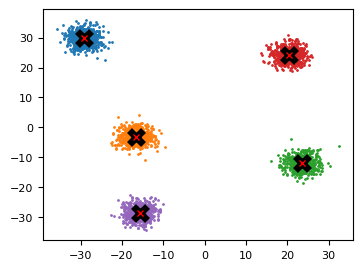

In [49]:
plot_data(centers,dat_l)

tensor([0., 1., 2., 3., 4., 5.])

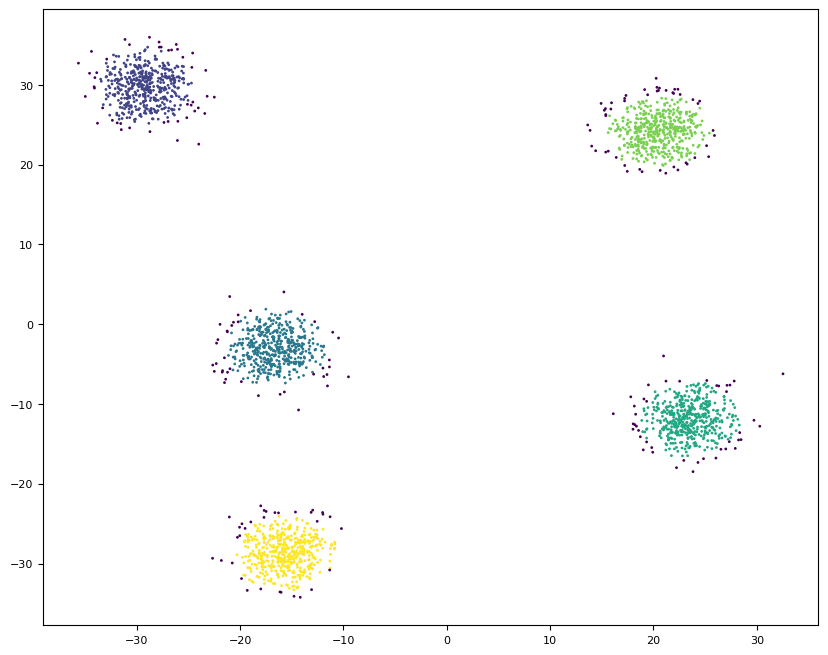

In [50]:
dbscan(dat, 2, 80, plot=True).unique()

In [51]:
X = dat.clone()
X = X[torch.randperm(X.shape[0])]

We can use the Data_hash class we developed in the `LSH - Locality-Sensitive Hashing` notebook:

In [52]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1, store_hash=False, n_matches=None): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        if dim == 2: self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        else: self.h_mat = torch.rand((dim, n_hash))-0.5
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        self.stored = False
        if store_hash:
            self.hash_dict = {}
            if n_matches: 
                self._store(n_matches)
                self._n_matches = n_matches
            else: 
                self._store(n_hash)
                self._n_matches = n_hash
            self.stored=True
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def _store(self, n_matches):
        for t in self.hashed:
            if tuple(t.tolist()) in self.hash_dict.keys(): continue
            k = tuple(t.tolist())
            idx = torch.where((t == self.hashed).sum(1)>n_matches)[0]
            self.hash_dict[k]=idx.tolist()
    
    def find_nns(self, x, n_matches):
        # find_nns will get the stored buckets if they exist and if the n_matches param
        # is equal to the init param n_matches, otherwise it will perform the comparison
        x_hash = self._hash(x)
        if self.stored and n_matches==self._n_matches:
            bucket = self.hash_dict[tuple(x_hash.tolist())]
            return _, torch.tensor(bucket)
        v_collide = (x_hash == self.hashed).sum(1)
        nns = torch.where(v_collide >= n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-5,6):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))/self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [53]:
# Hash the data
X_hash = Data_hash(X, X.shape[1], 20, scale_factor=0.05, store_hash=True, n_matches=16)
X_hash.hashed.shape

torch.Size([2500, 20])

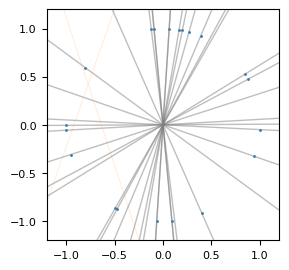

In [54]:
# Plot the hash directions and hash lines
X_hash.plot_hd()

In [56]:
len(X_hash.hash_dict), X_hash._n_matches

(1631, 16)

In [57]:
# Pick a random point
pt = X[torch.randint(X.shape[0],(1,))][0]

In [58]:
# Generate its nearest neighbors
_, ref_nns = X_hash.find_nns(pt,16)

In [59]:
# The nns lists for 16 collisions are stored
%timeit -n 50 _, ref_nns = X_hash.find_nns(pt,16)

39.7 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [60]:
# The nns lists for k=!16 collisions need to be caclulated
%timeit -n 50 _, ref_nns = X_hash.find_nns(pt,20)

The slowest run took 6.10 times longer than the fastest. This could mean that an intermediate result is being cached.
349 µs ± 308 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [61]:
X_hash._hash(pt).shape, (X_hash._hash(pt)==X_hash.hashed).shape

(torch.Size([20]), torch.Size([7500, 20]))

In [62]:
ref_nns

tensor([  38,   64,  192,  539,  620,  771,  842,  891, 1063, 1210, 1346, 1438, 1488, 1782, 1810, 1899, 2370, 2382, 2410, 2597, 2609, 2637,
        2992, 3003, 3016, 3056, 3202, 3242, 3308, 3537, 3892, 4042, 4284, 4416, 4465, 4521, 4746, 4756, 4797, 4940, 5051, 5196, 5425, 5533,
        5801, 5902, 5918, 5920, 6008, 6087, 6122, 6185, 6640, 6736, 6740, 6831, 6855, 6923, 7014, 7340, 7403])

In [63]:
X_hash.hashed[:,None,:].shape, X_hash.hashed.shape

(torch.Size([7500, 1, 20]), torch.Size([7500, 20]))

We can compare every point's hash with the others:

In [64]:
# Boolean symmetric n x n matrix of hash similarity between all points
%timeit -n 2 nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)

365 ms ± 63.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [65]:
nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)
nns_bool.shape

torch.Size([7500, 7500, 20])

However the calculation can get very large, quite slow, and breaks even for a rather small number of points. <br>
The point to address is, if possible, to get a method that compares the hashes values in a shorter time than the boolean comparison above.<br><br>

We can try the cosine similarity: $$\frac{A\cdot B}{\lVert A\rVert \times \lVert B\rVert}$$ 

Here the normalizing factor $\lVert A\rVert \times \lVert B\rVert$ is the diagonal of the matrix.

We can get the cos similarity and other comparison tools from the `NNS - Nearest Neighbor Search and dot product` notebook:

In [66]:
dot_mat = X_hash.hashed @ X_hash.hashed.transpose(0,1)
dot_mat[:3]

tensor([[ 121.,    9.,  107.,  ...,   17.,   -3., -157.],
        [   9.,  915.,   32.,  ...,  916.,  823.,  360.],
        [ 107.,   32.,   98.,  ...,   39.,   18., -131.]])

In [67]:
torch.einsum('ij,kj->ik', X_hash.hashed, X_hash.hashed)[:3]

tensor([[ 121.,    9.,  107.,  ...,   17.,   -3., -157.],
        [   9.,  915.,   32.,  ...,  916.,  823.,  360.],
        [ 107.,   32.,   98.,  ...,   39.,   18., -131.]])

In [68]:
%timeit -n 30 X_hash.hashed @ X_hash.hashed.transpose(0,1)

29.4 ms ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [69]:
%timeit -n 30 torch.einsum('ij,kj->ik',X_hash.hashed,X_hash.hashed)

29.4 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 30 loops each)


The einsum implementation is similar in speed to the @ matrix multiply operator here.

In [70]:
dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]

In [71]:
norm_mat = dot_diag@dot_diag.transpose(0,1)
norm_mat.shape, norm_mat[:5,:5]

(torch.Size([7500, 7500]),
 tensor([[121.000, 332.739, 108.894, 335.635, 296.796],
         [332.739, 915.000, 299.449, 922.965, 816.162],
         [108.894, 299.449,  98.000, 302.056, 267.103],
         [335.635, 922.965, 302.056, 931.000, 823.267],
         [296.796, 816.162, 267.103, 823.267, 728.000]]))

In [72]:
dot_mat/dot_mat.diag(0)[:,None]

tensor([[ 1.000,  0.074,  0.884,  ...,  0.140, -0.025, -1.298],
        [ 0.010,  1.000,  0.035,  ...,  1.001,  0.899,  0.393],
        [ 1.092,  0.327,  1.000,  ...,  0.398,  0.184, -1.337],
        ...,
        [ 0.018,  0.995,  0.042,  ...,  1.000,  0.896,  0.380],
        [-0.004,  1.106,  0.024,  ...,  1.109,  1.000,  0.457],
        [-0.433,  0.992, -0.361,  ...,  0.964,  0.937,  1.000]])

In [55]:
def cossim(X_h):
    dot_mat = X_h @ X_h.transpose(0,1)
    dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
    norm_mat = dot_diag@dot_diag.transpose(0,1)
    sim_mat = dot_mat/norm_mat
    return sim_mat

In [93]:
sim_mat = cossim(X_hash.hashed)

In [94]:
sim_mat.max()

tensor(1.000)

In [95]:
%timeit -n 2 _ = cossim(X_hash.hashed)

91.4 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


The cos similarity is about 3 times faster than the boolean comparison. 

With the cosine similarity matrix we can set a threshold equivalent to `n_match` :

In [96]:
dissim_bool = sim_mat<-0.5
sim_bool = sim_mat>0.993

In [97]:
sim_bool[150].nonzero().squeeze()

tensor([ 110,  150,  176,  675,  859, 2415, 2579, 3068, 3169, 3230, 3416, 3427, 4202, 4996, 5002, 5117, 5263, 5992, 6478, 6993, 7347, 7383,
        7463])

In [56]:
def plot_nns(pt, nns, X, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1), alpha=0.2, color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
#     ax.set_xlim(-50, 0)
#     ax.set_ylim(0, 60);

In [57]:
plot_nns(X[150], sim_bool[150].nonzero().squeeze(), X)

NameError: name 'sim_bool' is not defined

The cutoff is correct for a narrow interval of values within $[1-\epsilon, 1]$, $\epsilon$ small (here 0.007). But when the cutoff gets below $1-\epsilon$, the cos sim starts to pick points that are far but within the same angle (measured from the origin).
The problem is that the similarity only depends on the angle of the vectors, whereas here the magnitude carries important information. <br> 
We can normalize the hashed values in $\left[-1,1\right]$ to homogenize the vectors magnitude and use the dot product multiplied by a factor that accounts for the magnitude of the dot product simetrically around the reference point's norm.<br>

> We can import the following function from the `NNS - Nearest Neighbor Search and dot product` notebook:

In [58]:
def normalize(X):
    Xmin, Xmax = X.min(), X.max()
    return 2*(X-Xmin)/(Xmax-Xmin) - 1

In [59]:
def sim_matrix_(X, quick=True, f=1):
    X_norm = normalize(X)
    dot_mat = X_norm @ X_norm.transpose(0,1)
    dot_diag = torch.sqrt(dot_mat.diagonal(0))[:,None]
    norm_mat = dot_diag@dot_diag.transpose(0,1)
    if quick: mag_mat = torch.exp(-abs(dot_diag-dot_diag.transpose(0,1))*f)
    else: mag_mat = torch.exp(-torch.sqrt(((X_norm[:,None,:] - X_norm)**2).sum(2)))
    sim_mat = dot_mat/norm_mat*mag_mat 
    return sim_mat

The idea is to have both information on the angular similarity and the magnitude similarity. The angular similarity is given by the dot product, the magnitude comparison can be obtained by the difference of the norms $\lVert \textbf{u} \lVert - \lVert \textbf{v} \lVert$ with `quick=True`. This calculation is fast but the difference has a spherical symmetry and will tend to select nns along the arc of a circle of radius $\lVert \textbf{u} \lVert-\delta < r < \lVert \textbf{u} \lVert+\delta$. The factor `f` corrects the radial expansion of the nn selection.

In [111]:
sim_mat = sim_matrix_(X, quick=True, f=0.2)

In [112]:
sim_bool = sim_mat>0.995

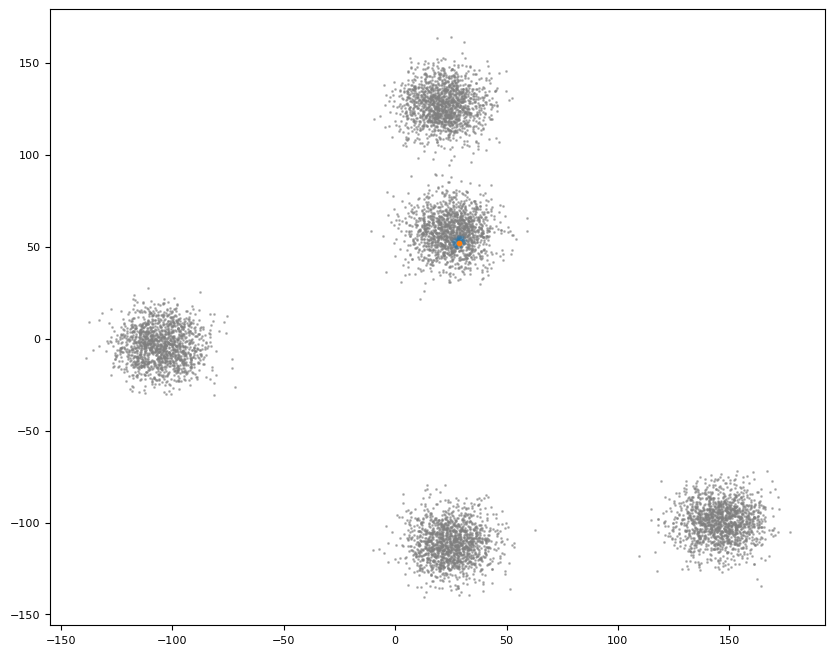

In [113]:
plot_nns(X[150], sim_bool[150].nonzero().squeeze(), X)

In [114]:
%timeit -n 2 _ = sim_matrix_(X, quick=True, f=0.05)

304 ms ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


This method is good but it needs a good combination of values of `f` and the cutoff. And it is not better in terms of performance than the boolean comparison.

#### DBSCAN with LSH

Now we can calculate the matrix of nearest neighbors, let's verify: 
- first if it is a fast calculation
- second if adding the epsilon cuttof and thus the distance calculation is still interesting performance wise (for meanshift, we can just use these approximate nearest neighbors to calculate each new point position)

> We'll need both a '**radius**' and  number of points to define core points. <br>
 We need to set a `minPts` parameter and $\epsilon$ is replaced here by the `n_match` parameter, which gives a sense of locality but much looser than the real $\epsilon$ of DBSCAN. Let's see how it performs. 


In [55]:
n_match = 7
minPts = 50

In [56]:
Xh = Data_hash(X, X.shape[1], 20, scale_factor=0.05, store_hash=True, n_matches=18)

In [57]:
nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)
nns_mat.shape

NameError: name 'nns_bool' is not defined

In [114]:
# Core point calculation
core_bool = nns_mat.sum(1)>minPts

In [115]:
#indexes of the core points
cb_idx = torch.where(core_bool)[0]
core_bool.sum(), cb_idx.shape

(tensor(2500), torch.Size([2500]))

In [60]:
def nns_matrix(X_hash, n_match, minPts):
    nns_bool = (X_hash.hashed[:,None,:] == X_hash.hashed)
    nns_mat = torch.where(nns_bool.sum(2)>=n_match, 1,0)
    core_bool = nns_mat.sum(1)>minPts
    return nns_mat, core_bool

In [61]:
def dbscan_lsh(data, n_hash, n_match, minPts, s, plot=False):
    X = data.clone()
    X_hash = Data_hash(X, X.shape[1], n_hash, scale_factor=s, store_hash=True, n_matches=n_match)
    nns_mat, core_bool = nns_matrix(X_hash,n_match, minPts)
    clust = find_c_fast(nns_mat, core_bool)
    if plot: plot_clusters(X, clust)
    return clust

tensor([0., 1., 2., 3., 4., 5.])

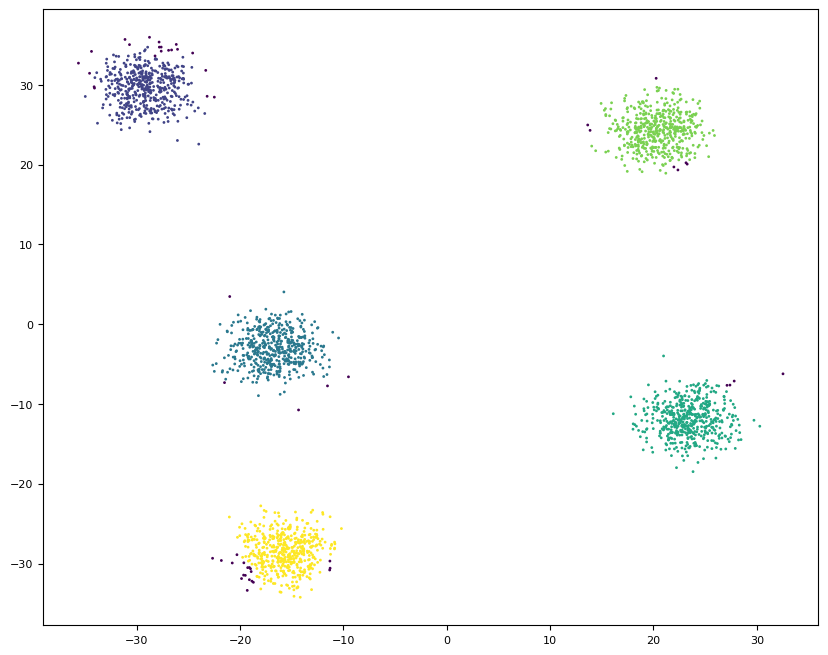

In [60]:
cl = dbscan_lsh(dat, 20, 16, 170, 0.08, plot=True)
cl.unique()

In [61]:
%timeit -n 2 _ = dbscan_fast(dat,2,50)

100 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [62]:
%timeit -n 2 _ = dbscan(dat,2,50)

149 ms ± 7.01 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [63]:
%timeit -n 2 _ = dbscan_lsh(dat, 20, 16, 120, 0.05)

261 ms ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


tensor([0., 1., 3., 5., 8., 9.])

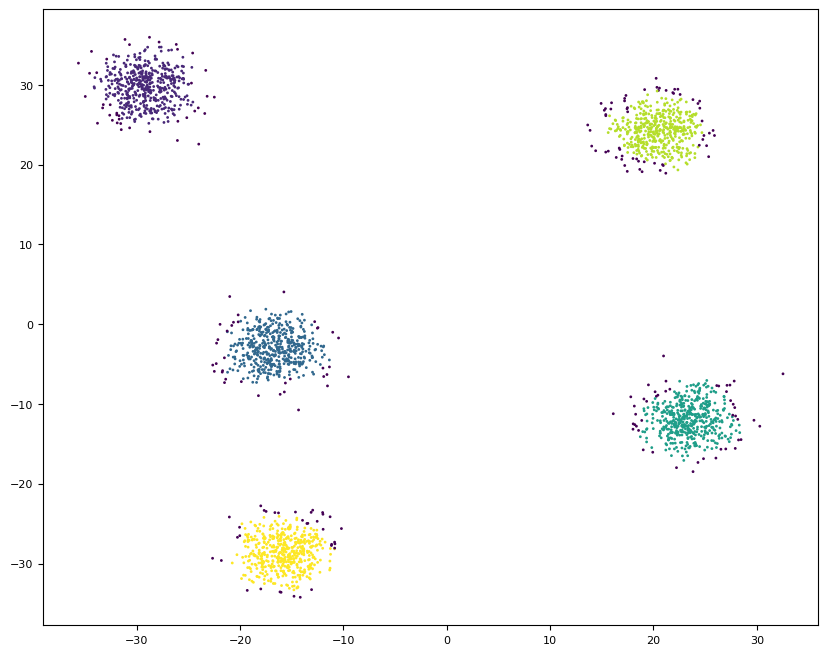

In [64]:
dbscan_fast(dat,2,50, plot=True).unique()

The point of LSH is to get the nearest neighbors without calculating the distances. <br>
We could think of an algorithm that groups points together based on hash similarity.. <br>

In [65]:
X = dat.clone()
X = X[torch.randperm(X.shape[0])]
# Xh = Data_hash(X, X.shape[1], 20, scale_factor=0.08, store_hash=True, n_matches=17)
Xh = Data_hash(X, X.shape[1], 20, scale_factor=0.1, store_hash=True, n_matches=15)

In [66]:
_, nns = Xh.find_nns(X[30], 15)

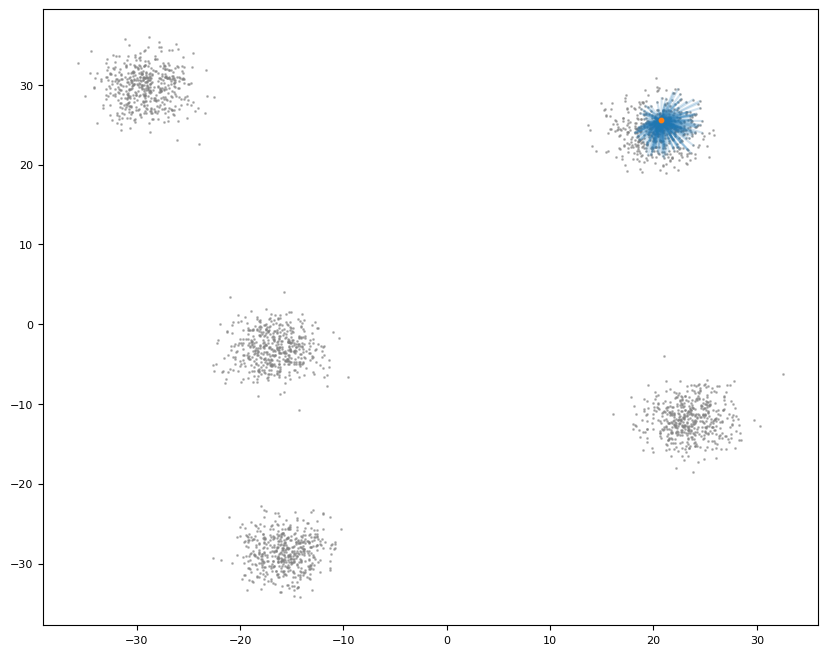

In [67]:
plot_nns(X[30], nns, X)

In [68]:
minPts = 70

In [69]:
clu = torch.zeros(X.shape[0])
core_d = torch.tensor([-1])
i = 1
for j,p in enumerate(X):
    _, nns = Xh.find_nns(p,15)
    if len(nns) < minPts or j in core_d: continue 
    core_d = torch.cat((core_d,nns))
    if clu[nns].sum()>0:
        nn_idx = nns[torch.where(clu[nns])[0]]
        min_c = clu[nn_idx].min() 
        for n in clu[nn_idx].unique():
            if n == 0: continue
            idx = torch.where(clu==n)[0]
            clu[idx] = min_c
        clu[nns] = min_c
    else:
        clu[nns] = i
        i += 1

In [71]:
clu.unique()

tensor([0., 1., 2., 3., 4., 5.])

In [62]:
def lsh_clusters(Xh, n_match, minPts):
    clu = torch.zeros(X.shape[0])
    core_d = torch.tensor([-1])
    i = 1
    for j,p in enumerate(X):
        _, nns = Xh.find_nns(p,n_match)
        if len(nns) < minPts or j in core_d: continue 
        core_d = torch.cat((core_d,nns))
        if clu[nns].sum()>0:
            nn_idx = nns[torch.where(clu[nns])[0]]
            min_c = clu[nn_idx].min() 
            for n in clu[nn_idx].unique():
                if n == 0: continue
                idx = torch.where(clu==n)[0]
                clu[idx] = min_c
            clu[nns] = min_c
        else:
            clu[nns] = i
            i += 1
    return clu

In [101]:
clu = lsh_clusters(Xh, 15, minPts)

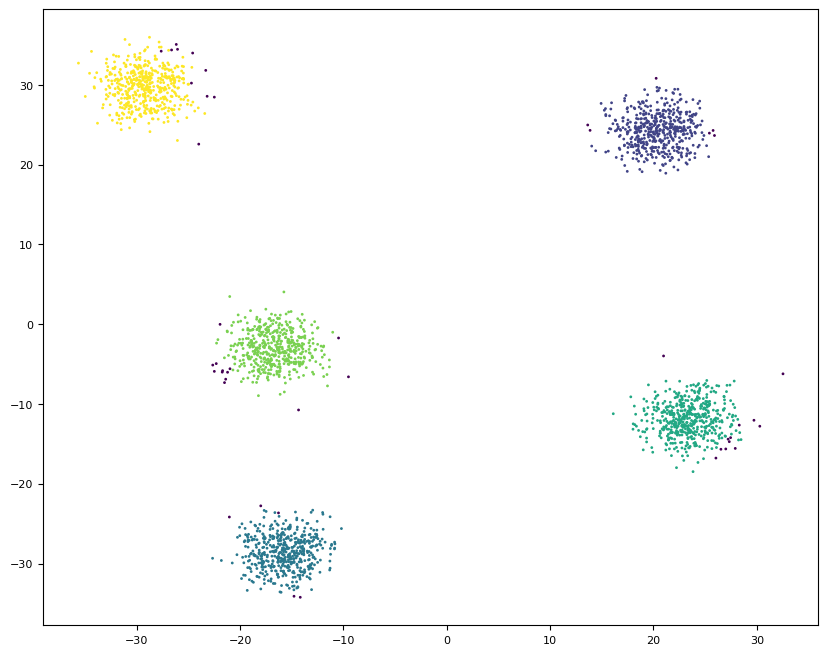

In [102]:
plot_clusters(X, clu)

In [103]:
%timeit -n 2 _ = lsh_clusters(Xh, 15, minPts)

163 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


The performance is similar to the `dbscan` function version.

#### Animation with LSH

Here again, we use a list of the indexes of the points that change the `clu` values to have a continuous and shorter movie:

In [104]:
main_idx = [] # ADDED TO EXTRACT ONLY THE IMPORTANT POINTS FOR THE MOVIE FRAMES 
clu = torch.zeros(X.shape[0])
core_d = torch.tensor([-1])
i = 1
# for j in midx:
#     p = X[j]
for j,p in enumerate(X):
    _, nns = Xh.find_nns(p,15)
    if len(nns) < minPts or j in core_d: continue
    main_idx.append(j)  # ADDED TO EXTRACT ONLY THE IMPORTANT POINTS FOR THE MOVIE FRAMES  
    core_d = torch.cat((core_d,nns))
    if clu[nns].sum()>0:
        nn_idx = nns[torch.where(clu[nns])[0]]
        min_c = clu[nn_idx].min() 
        for n in clu[nn_idx].unique():
            if n == 0: continue
            idx = torch.where(clu==n)[0]
            clu[idx] = min_c
        clu[nns] = min_c
    else:
        clu[nns] = i
        i += 1

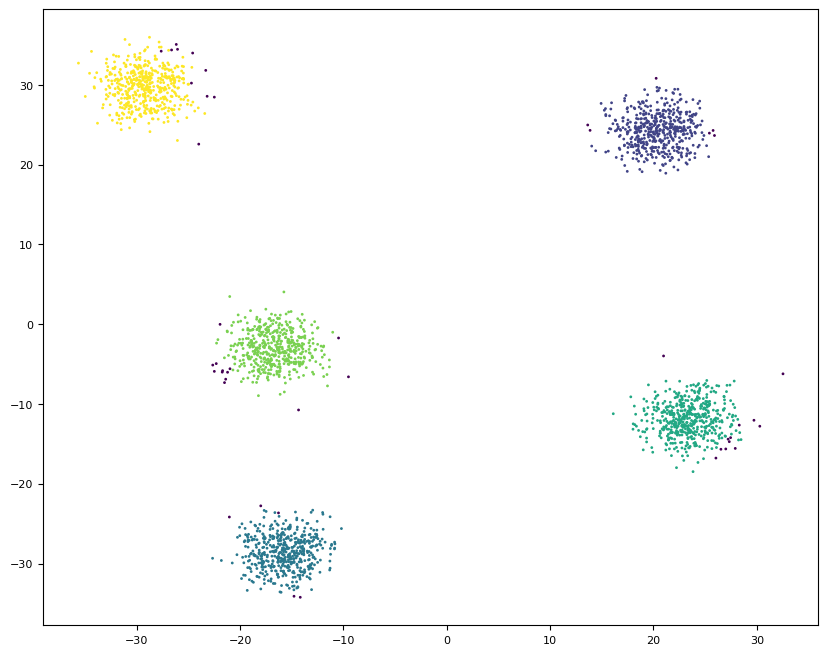

In [105]:
plot_clusters(X, clu)

In [106]:
midx = tensor(main_idx) # ADDED TO EXTRACT ONLY THE IMPORTANT POINTS FOR THE MOVIE FRAMES 

In [107]:
midx

tensor([   0,    1,    2,    3,    4,    5,    6,    8,   11,   12,   14,   21,   39,   62,   75,   93,   96,  128,  149,  166,  249,  271,
         289,  309,  366,  397,  964, 2172])

In [108]:
def one_stp(d):
    global i
    global core_d
    if d:
        p = X[midx[d-1]]
        _, nns = Xh.find_nns(p,15)
        if len(nns) < minPts or midx[d-1] in core_d: return
        core_d = torch.cat((core_d,nns))
        if clu[nns].sum()>0:
            nn_idx = nns[torch.where(clu[nns])[0]]
            min_c = clu[nn_idx].min() 
            for n in clu[nn_idx].unique():
                if n == 0: continue
                idx = torch.where(clu==n)[0]
                clu[idx] = min_c
            clu[nns] = min_c
        else:
            clu[nns] = i
            i += 1
    ax.clear()
    plot_clusters(X, clu, ax=ax)

In [109]:
minPts = 70
clu = torch.zeros(X.shape[0])
core_d = torch.tensor([-1])
i = 1

In [110]:
n_frames = midx.shape[0]+1
# n_frames = 500
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, one_stp, frames=n_frames, interval=500, repeat=False)
plt.close()
# HTML(ani.to_jshtml())
HTML(ani.to_html5_video())
# ani.save('test.mp4')

One might extract notions of density from LSH and use it as a real density based clustering method.

#### GPU acceleration

The problem with DBSCAN are the loops to verify the cluster associations, to accelerate this algorithm, we would need to rethink its implementation to get rid of the loops and conditions as much as possible.<br>
Maybe let the clusters form and at the end harmonize the clusters? Or by having a neighbors tree? See GPU accelerated [Random Forest](https://developer.nvidia.com/blog/accelerating-random-forests-up-to-45x-using-cuml/) and [HDBSCAN](https://developer.nvidia.com/blog/gpu-accelerated-hierarchical-dbscan-with-rapids-cuml-lets-get-back-to-the-future/).

We can still see how this implementation performs when naively thrown at the GPU:

In [95]:
dat = dat.cuda()

In [78]:
eps = 3
minPts = 150

In [101]:
def find_c_fast_gpu(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape).cuda()
    core_n_idx = torch.where(core_bool)[0]
    core_done = torch.tensor([-1]).cuda() # just to initialize the tensor
    i = 1
    for k in core_n_idx:
        if k in core_done: continue
        u = neighbors[k]
        u_idx = torch.where(u)[0]
        core_done = torch.cat((core_done,u_idx))
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [87]:
def find_c_gpu(neighbors, core_bool):
    clusters = torch.zeros(core_bool.shape).cuda()
    core_n_idx = torch.where(core_bool)[0]
    i = 1
    for u in neighbors[core_n_idx]:
        u_idx = torch.where(u)[0]
        if clusters[u_idx].sum() > 0:
            nn_idx = u_idx[torch.where(clusters[u_idx])[0]]   # nearest neighbors indexes that already have a non-zero cluster value
            if u_idx.shape == nn_idx.shape: continue          # if the point and its neighbors are already labelled, continue
            c_num = clusters[nn_idx].min()                    # cluster number
            for n in clusters[nn_idx].unique():               # all points that share a common cluster number with the nearest neighbors (sub graph)
                idx = torch.where(clusters==n)[0] 
                clusters[idx] = c_num
            clusters[u_idx] = c_num
        else:
            clusters[u_idx] = i
            i += 1
    return clusters

In [102]:
def dbscan_gpu(data, eps, minPts, plot=False):
    X = data.clone()
    D = distance_matrix(X)
    neighbors, core_bool = core_pts_calc(D, eps, minPts)
    clust = find_c_fast_gpu(neighbors, core_bool)
    if plot: plot_clusters(X.cpu(), clust.cpu())
    return clust

tensor([1., 1., 1.,  ..., 5., 5., 5.], device='cuda:0')

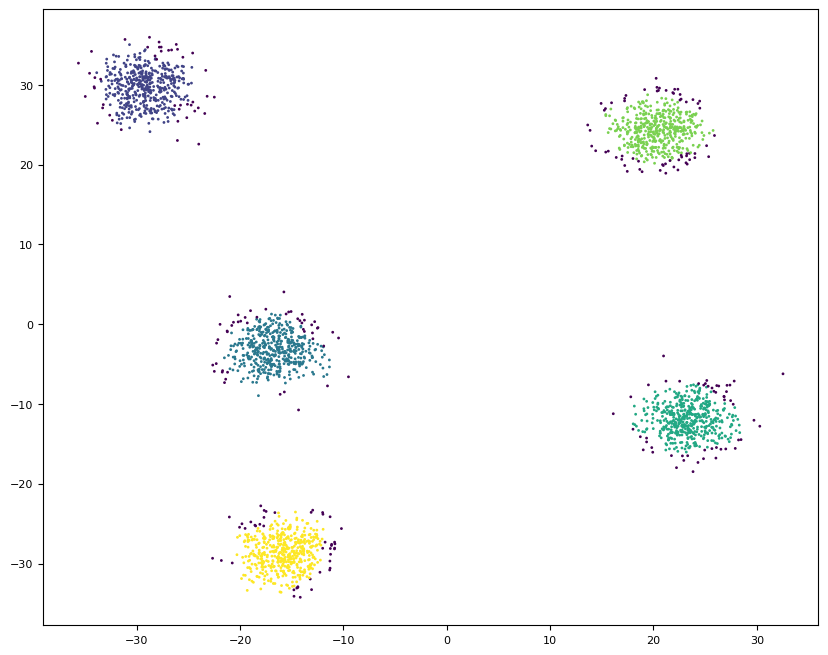

In [104]:
dbscan_gpu(dat, eps, minPts, plot=True)

In [105]:
%time dbscan_gpu(dat, eps, minPts, plot=False)

CPU times: user 303 ms, sys: 8.78 ms, total: 312 ms
Wall time: 310 ms


tensor([1., 1., 1.,  ..., 5., 5., 5.], device='cuda:0')

In [96]:
%time dbscan_gpu(dat, eps, minPts, plot=False)

CPU times: user 951 ms, sys: 65.9 ms, total: 1.02 s
Wall time: 1.02 s


tensor([1., 1., 1.,  ..., 5., 5., 5.], device='cuda:0')

In [93]:
dat = dat.cpu()
%time dbscan(dat, eps, minPts, plot=False)

CPU times: user 582 ms, sys: 154 ms, total: 735 ms
Wall time: 186 ms


tensor([1., 1., 1.,  ..., 5., 5., 5.])

#### exploration - selection of the LSH parameters

In [1050]:
# nearest neighbors list function of n_match
nn_num = []
for i in range(n_hashes):
    nn_num.append(torch.where(nns_bool.sum(2)>=i, 1,0).sum(1).tolist())

In [1051]:
# list of nearest neighbors for 0 <= n_match <= n_hash
nn_num = []
for i in range(X_hash.n_h):
    nn_num.append(torch.where(nns_bool[cb_idx].sum(2)>=i, 1,0).sum(1).tolist())

In [1052]:
torch.tensor(nn_num).shape, torch.tensor(nn_num)

(torch.Size([20, 1691]),
 tensor([[2500, 2500, 2500,  ..., 2500, 2500, 2500],
         [1323, 1168, 1321,  ...,  775,  758,  780],
         [ 743,  724,  626,  ...,  407,  411,  434],
         ...,
         [  10,    8,    6,  ...,   12,    6,   14],
         [   9,    4,    4,  ...,   10,    4,   11],
         [   5,    4,    3,  ...,    8,    3,    2]]))

In [1053]:
torch.tensor(nn_num)[1].min()

tensor(573)

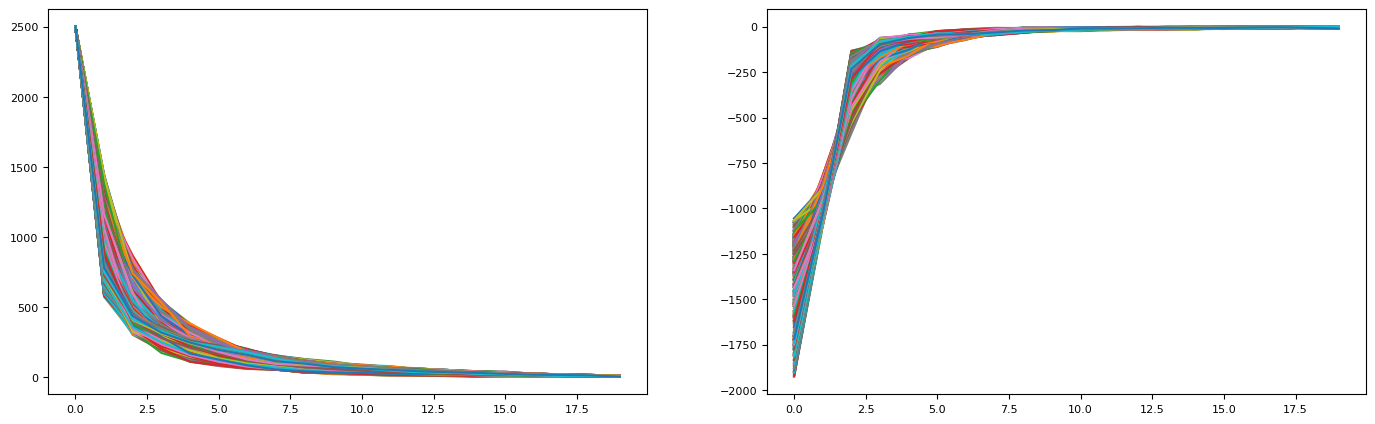

In [1054]:
fig, axs = plt.subplots(1, 2, figsize=(17,5))
for u in torch.tensor(nn_num).transpose(0,1):
    axs[0].plot(u)
    axs[1].plot(torch.gradient(u)[0])

#### Tests hash non lineaires

In [563]:
class Data_hash_():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        self.h_mat = torch.rand((dim,n_hash))
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(torch.stack((X[:,0]**2, X[:,0],X[:,1]),dim=1) @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide > n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-2,3):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))*self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.2, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [572]:
modX = Data_hash_(X,3,10,scale_factor=0.1)

In [573]:
x = X[torch.randint(X.shape[0],(1,))]

In [576]:
_, rf_nns = modX.find_nns(x, 0)

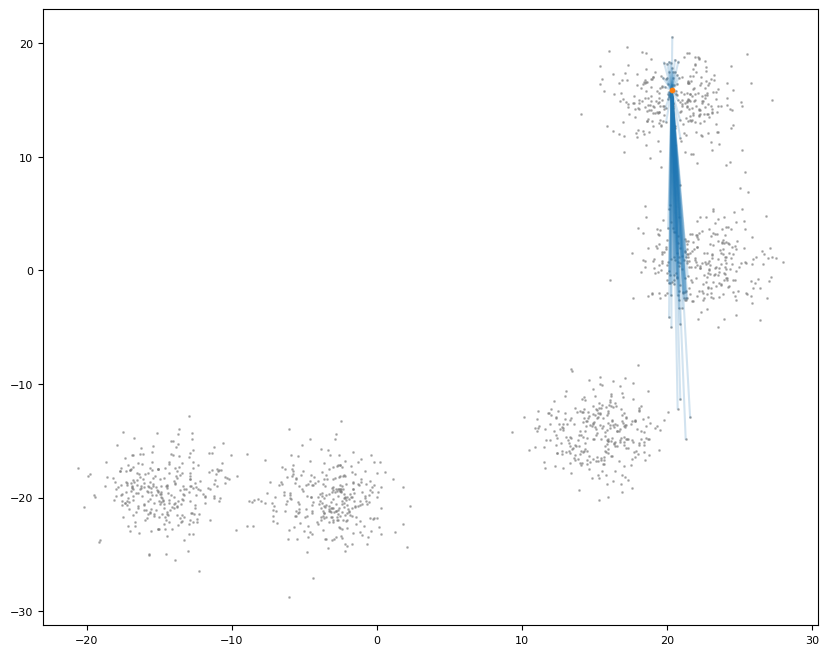

In [577]:
plot_nns(x[0], rf_nns, X)